## Regression Problem: House Prices Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the house selling prices .

**Dataset:**  A csv file with 1460 samples is provided (on the course webpage). Each example contains four input features. We will use 1000 examples as training set, 200 as validation set and the rest as test set.   
   * **Feature names**: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea
   * **Target**: SalePrice

**NB:** new required libraries: `pandas`, `seaborn`.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [6]:
# Load data:
df = pd.read_csv("house_prices.csv")

In [7]:
df.head(3)

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,SalePrice
0,7,2003,856,1710,208500
1,6,1976,1262,1262,181500
2,7,2001,920,1786,223500


In [8]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   OverallQual  1460 non-null   int64
 1   YearBuilt    1460 non-null   int64
 2   TotalBsmtSF  1460 non-null   int64
 3   GrLivArea    1460 non-null   int64
 4   SalePrice    1460 non-null   int64
dtypes: int64(5)
memory usage: 57.2 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

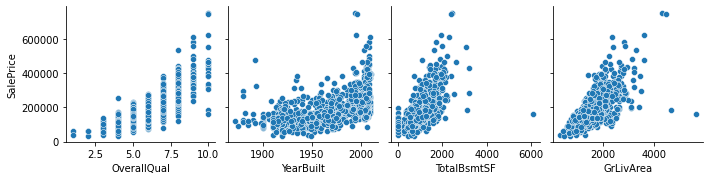

In [9]:
sns.pairplot(df, x_vars=['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea'], 
             y_vars=['SalePrice'])

# Preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df) 
scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns)
print(scaled_df)

      OverallQual  YearBuilt  TotalBsmtSF  GrLivArea  SalePrice
0        0.666667   0.949275     0.140098   0.259231   0.241078
1        0.555556   0.753623     0.206547   0.174830   0.203583
2        0.666667   0.934783     0.150573   0.273549   0.261908
3        0.666667   0.311594     0.123732   0.260550   0.145952
4        0.777778   0.927536     0.187398   0.351168   0.298709
...           ...        ...          ...        ...        ...
1455     0.555556   0.920290     0.155974   0.247362   0.194556
1456     0.555556   0.768116     0.252373   0.327619   0.243161
1457     0.666667   0.500000     0.188543   0.377920   0.321622
1458     0.444444   0.565217     0.176432   0.140166   0.148903
1459     0.444444   0.673913     0.205565   0.173700   0.156367

[1460 rows x 5 columns]


### House prices prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [11]:
X = scaled_df[['OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea']] # get the four features from the dataframe
y = scaled_df['SalePrice'] # get the target values

In [12]:
X_train = X.iloc[:1000]
y_train = y.iloc[:1000]

X_val = X.iloc[1000:1200]
y_val = y.iloc[1000:1200]

X_test = X.iloc[1200:]
y_test = y.iloc[1200:]

In [13]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(4, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [14]:
# Define hyper-parameters:
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [15]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # creat the dataset.

In [16]:
test_set = TensorDataset(torch.from_numpy(np.array(X_test)).float(), 
                          torch.from_numpy(np.array(y_test)).float()) # creat the dataset.

In [17]:
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    dataloader = DataLoader(dataset, batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):

            y_pre = model(X).view(-1)
            loss = criterion(y_pre, y)
            # print(y_pre, y)
            # loss = Lozz(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
            
        if ((epoch+1)%1 == 0):
                print('Epoch [{}/{}], Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss))
                

In [18]:
train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss_error: 0.0600
Epoch [2/10], Loss_error: 0.0229
Epoch [3/10], Loss_error: 0.0216
Epoch [4/10], Loss_error: 0.0205
Epoch [5/10], Loss_error: 0.0193
Epoch [6/10], Loss_error: 0.0182
Epoch [7/10], Loss_error: 0.0173
Epoch [8/10], Loss_error: 0.0164
Epoch [9/10], Loss_error: 0.0155
Epoch [10/10], Loss_error: 0.0147


#### Evaluate the Model on the validation set

In [19]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 0.016338875517249107


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


In [20]:
# y_label = torch.tensor(np.array(y_val)).float()
# sigma = 1

In [21]:
def Lozz(y_pre_val, y_label):
  return 1 - (1/2)*(np.log(2*np.pi*(sigma**2)) + ((y_pre_val - y_label)**2) /sigma**2)

In [22]:
critireon = nn.GaussianNLLLoss()
train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss_error: 0.0140
Epoch [2/10], Loss_error: 0.0133
Epoch [3/10], Loss_error: 0.0127
Epoch [4/10], Loss_error: 0.0120
Epoch [5/10], Loss_error: 0.0115
Epoch [6/10], Loss_error: 0.0110
Epoch [7/10], Loss_error: 0.0105
Epoch [8/10], Loss_error: 0.0100
Epoch [9/10], Loss_error: 0.0096
Epoch [10/10], Loss_error: 0.0092


In [23]:
# Calculate mean squared error on validation set
model.eval()
with torch.no_grad():
    y_pre_val = model(torch.from_numpy(np.array(X_val)).float()).view(-1)
error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
print('The loss on validation set is:', error)

The loss on validation set is: 0.010598269291222095


### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `OverallQual` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.

In [24]:
# Calculate mean squared error on test set
model.eval()
with torch.no_grad():
    y_pre_test = model(torch.from_numpy(np.array(X_test)).float()).view(-1)
error = criterion(y_pre_test, torch.tensor(np.array(y_test)).float()).item()
print('The loss on test set is:', error)

The loss on test set is: 0.007172432728111744
